In [71]:
# Import the needed libraries
import pandas as pd
import re
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, classification_report
import itertools
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import seaborn

In [72]:
# stor the dataset into different datafram 
train_text_df = pd.read_csv('train_text.csv', header=0, encoding= 'unicode_escape')
train_labels_df = pd.read_csv('train_labels.csv', header=0, encoding= 'unicode_escape')
test_text_df = pd.read_csv('test_text.csv', header=0, encoding= 'unicode_escape')
test_labels_df = pd.read_csv('test_labels.csv', header=0, encoding= 'unicode_escape')
val_text_df = pd.read_csv('val_text.csv', header=0, encoding= 'unicode_escape')
val_labels_df = pd.read_csv('val_labels.csv', header=0, encoding= 'unicode_escape')

In [73]:
# preprocessing train data using Regular Expression
for i in range(len(train_text_df['Text'])):
    train_text_df['Text'][i]=re.sub(r'http\S+', '', train_text_df['Text'][i]) 
    train_text_df['Text'][i]=re.sub("[^a-zA-Z]", " ", train_text_df['Text'][i])

In [74]:
# preprocessing test data using Regular Expression
for i in range(len(test_text_df['Text'])):
    test_text_df['Text'][i]=re.sub(r'http\S+', '', test_text_df['Text'][i]) 
    test_text_df['Text'][i]=re.sub("[^a-zA-Z]", " ", test_text_df['Text'][i])

In [75]:
# preprocessing validation data using Regular Expression
for i in range(len(val_text_df['Text'])):
    val_text_df['Text'][i]=re.sub(r'http\S+', '', val_text_df['Text'][i]) 
    val_text_df['Text'][i]=re.sub("[^a-zA-Z]", " ", val_text_df['Text'][i])

In [104]:
# Combine the text of train, test and validation datasets for embedding
dataset = pd.concat([train_text_df, test_text_df])
dataset = pd.concat([dataset, val_text_df])

In [105]:
# Combine the label of train, test and validation datasets for embedding
labelset = pd.concat([train_labels_df, test_labels_df])
labelset = pd.concat([labelset, val_labels_df])

In [78]:
# The tokenization process
max_fatures = 2000
tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(dataset['Text'].values)
X = tokenizer.texts_to_sequences(dataset['Text'].values)
X = pad_sequences(X)

In [79]:
# Split the dataset again into train, test and validation 
X_train = X[0:45000, :]
X_test = X[45000:95000, :]
X_val = X[95000:, :]
Y_train = pd.get_dummies(train_labels_df['Label']).values
Y_test = pd.get_dummies(test_labels_df['Label']).values
Y_val = pd.get_dummies(val_labels_df['Label']).values

print('Train: ', X_train.shape,Y_train.shape)
print('Test : ', X_test.shape,Y_test.shape)
print('Valid: ', X_val.shape,Y_val.shape)

Train:  (45000, 36) (45000, 20)
Test :  (50000, 36) (50000, 20)
Valid:  (5000, 36) (5000, 20)


In [93]:
# Create an LSTM model
embed_dim = 128
lstm_out = 196

model = Sequential()
model.add(Embedding(max_fatures, embed_dim,input_length = X.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(lstm_out, dropout=0.4, recurrent_dropout=0.4, activation = 'relu'))
model.add(Dense(20,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])#sparse_categorical_crossentropy
print(model.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 36, 128)           256000    
_________________________________________________________________
spatial_dropout1d_5 (Spatial (None, 36, 128)           0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 196)               254800    
_________________________________________________________________
dense_5 (Dense)              (None, 20)                3940      
Total params: 514,740
Trainable params: 514,740
Non-trainable params: 0
_________________________________________________________________
None


In [94]:
# Train the model
batch_size = 32
history = model.fit(X_train, Y_train, epochs = 5, batch_size = batch_size, validation_data = (X_val, Y_val), verbose = 2)

Epoch 1/5
1407/1407 - 73s - loss: 2.6106 - accuracy: 0.2380 - val_loss: 2.4679 - val_accuracy: 0.2766
Epoch 2/5
1407/1407 - 70s - loss: 2.4083 - accuracy: 0.2925 - val_loss: 2.4152 - val_accuracy: 0.2910
Epoch 3/5
1407/1407 - 71s - loss: 2.3389 - accuracy: 0.3089 - val_loss: 2.4019 - val_accuracy: 0.2934
Epoch 4/5
1407/1407 - 72s - loss: 2.2935 - accuracy: 0.3191 - val_loss: 2.4041 - val_accuracy: 0.2976
Epoch 5/5
1407/1407 - 72s - loss: 2.2620 - accuracy: 0.3260 - val_loss: 2.3925 - val_accuracy: 0.3022


In [95]:
# to plot the performane of the model
def plot_metric(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics)
    plt.plot(epochs, val_metrics)
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()

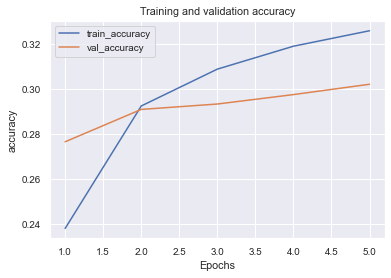

In [96]:
# to compare train accuracy and validation accuracy for overfitting verification
plot_metric(history, 'accuracy')

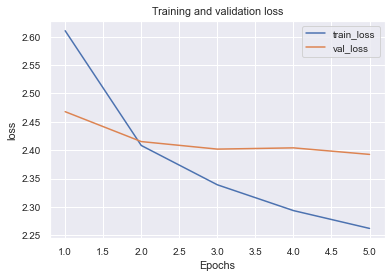

In [97]:
# to compare train loss and validation loss for overfitting verification
plot_metric(history, 'loss')

In [99]:
# Evaluate the model using test dataset
score,acc = model.evaluate(X_test, Y_test, verbose = 2, batch_size = batch_size)
print("score: %.2f" % (score))
print("acc: %.2f" % (acc))

1563/1563 - 27s - loss: 2.3733 - accuracy: 0.3101
score: 2.37
acc: 0.31


In [100]:
# Evaluate the model using test dataset by predict the emoji
pred = model.predict(X_test)

In [101]:
# Apply argmax on the prediction
prediction = []
for i in range(len(pred)):
    prediction.append(np.argmax(pred[i]))

real = []
for i in range(len(Y_test)):
    real.append(np.argmax(Y_test[i]))

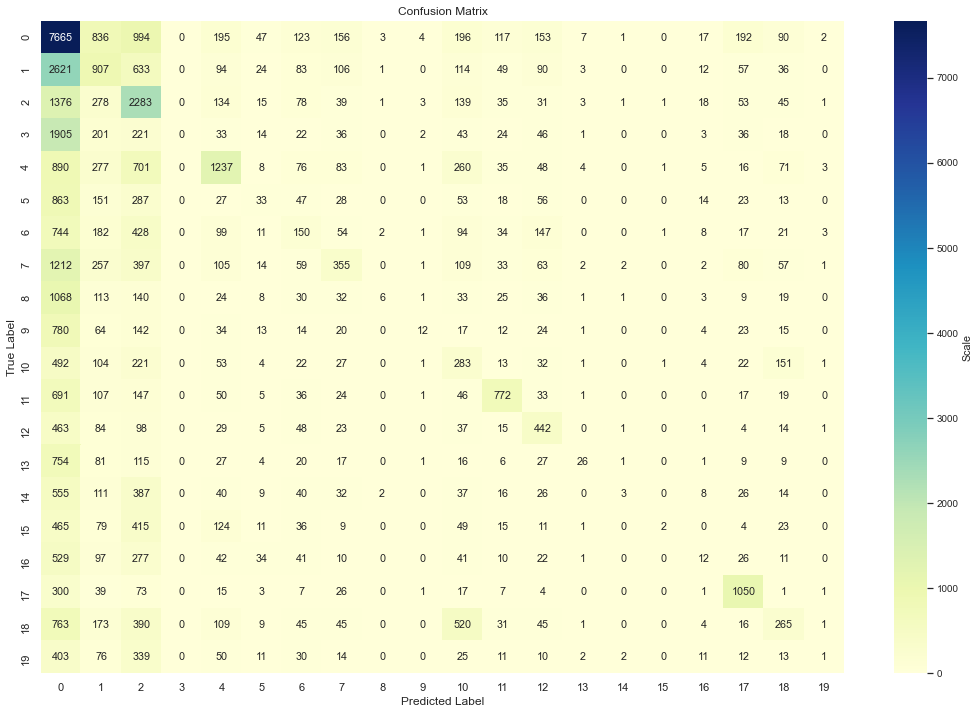

In [102]:
# Function to preduce the confusion matix

def plot_confusion_matrix(data, labels, output_filename):
    """Plot confusion matrix using heatmap.
 
    Args:
        data (list of list): List of lists with confusion matrix data.
        labels (list): Labels which will be plotted across x and y axis.
        output_filename (str): Path to output file.
 
    """
    seaborn.set(color_codes=True)
    plt.figure(1, figsize=(18, 12))
 
    plt.title("Confusion Matrix")
 
    seaborn.set(font_scale=0.9)
    ax = seaborn.heatmap(data, annot=True, fmt="d", cmap="YlGnBu", cbar_kws={'label': 'Scale'})
 
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)
 
    ax.set(ylabel="True Label", xlabel="Predicted Label")
 
    plt.show()
    plt.savefig(output_filename, bbox_inches='tight', dpi=300)
    plt.close()

confusion_mtx = confusion_matrix(real, prediction) 
# plot the confusion matrix
labels = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]
plot_confusion_matrix(confusion_mtx, labels, "confusion_matrix.png")

In [103]:
# Print the classification report
print(classification_report(real, prediction))

              precision    recall  f1-score   support

           0       0.31      0.71      0.43     10798
           1       0.22      0.19      0.20      4830
           2       0.26      0.50      0.35      4534
           3       0.00      0.00      0.00      2605
           4       0.49      0.33      0.40      3716
           5       0.12      0.02      0.03      1613
           6       0.15      0.08      0.10      1996
           7       0.31      0.13      0.18      2749
           8       0.40      0.00      0.01      1549
           9       0.41      0.01      0.02      1175
          10       0.13      0.20      0.16      1432
          11       0.60      0.40      0.48      1949
          12       0.33      0.35      0.34      1265
          13       0.47      0.02      0.04      1114
          14       0.25      0.00      0.00      1306
          15       0.33      0.00      0.00      1244
          16       0.09      0.01      0.02      1153
          17       0.62    

C:\Users\maa0664.UNT\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [58]:
# Calculat the accuracy, precision, recall and F1
accuracy = accuracy_score(real, prediction)
precision_macro = precision_score(real, prediction, average='macro')
precision_micro = precision_score(real, prediction, average='micro')

recall_macro = recall_score(real, prediction, average='macro')
recall_micro = recall_score(real, prediction, average='micro')

f1_macro = f1_score(real, prediction, average='macro')
f1_micro = f1_score(real, prediction, average='micro')

C:\Users\maa0664.UNT\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [59]:
# Print the accuracy, precision, recall and F1
print('accuracy        = ', accuracy)
print('precision_macro = ', precision_macro)
print('precision_micro = ', precision_micro)
print('recall_macro    = ', recall_macro)
print('recall_micro    = ', recall_micro)
print('f1_macro        = ', f1_macro)
print('f1_micro        = ', f1_micro)

accuracy        =  0.30182
precision_macro =  0.24650694613551377
precision_micro =  0.30182
recall_macro    =  0.1807630562475256
recall_micro    =  0.30182
f1_macro        =  0.16625404734063054
f1_micro        =  0.30182


In [61]:
#pip install emoji

In [65]:
import emoji
print(emoji.emojize(":grinning_face_with_big_eyes:"))
print(emoji.emojize(":red_heart:"))

😃
❤️
